## Car Selling Price Prediction


In [1]:
#installing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Data Collection and Preprocessing
car_dataset = pd.read_csv('car.csv')
car_dataset.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,14.000000


(8128, 12)


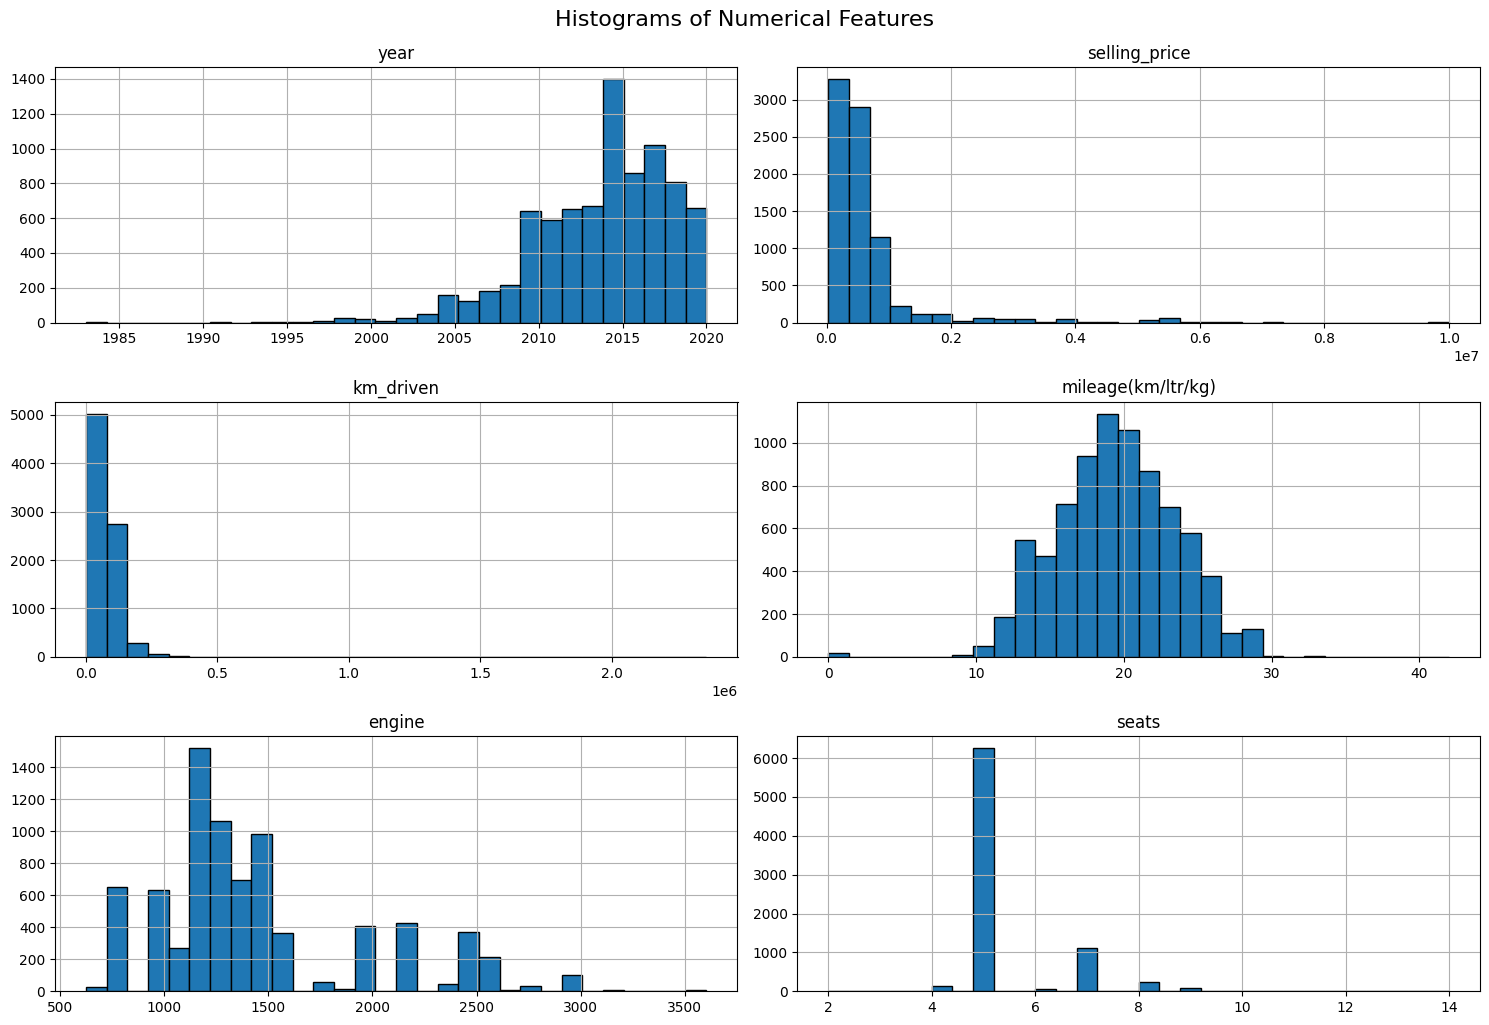

In [3]:
# Inspecting the dataset
print(car_dataset.shape)
import matplotlib.pyplot as plt

# Select only numerical columns
numeric_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram for each numerical column
car_dataset[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', fontsize=16, y=1.02)
plt.show()


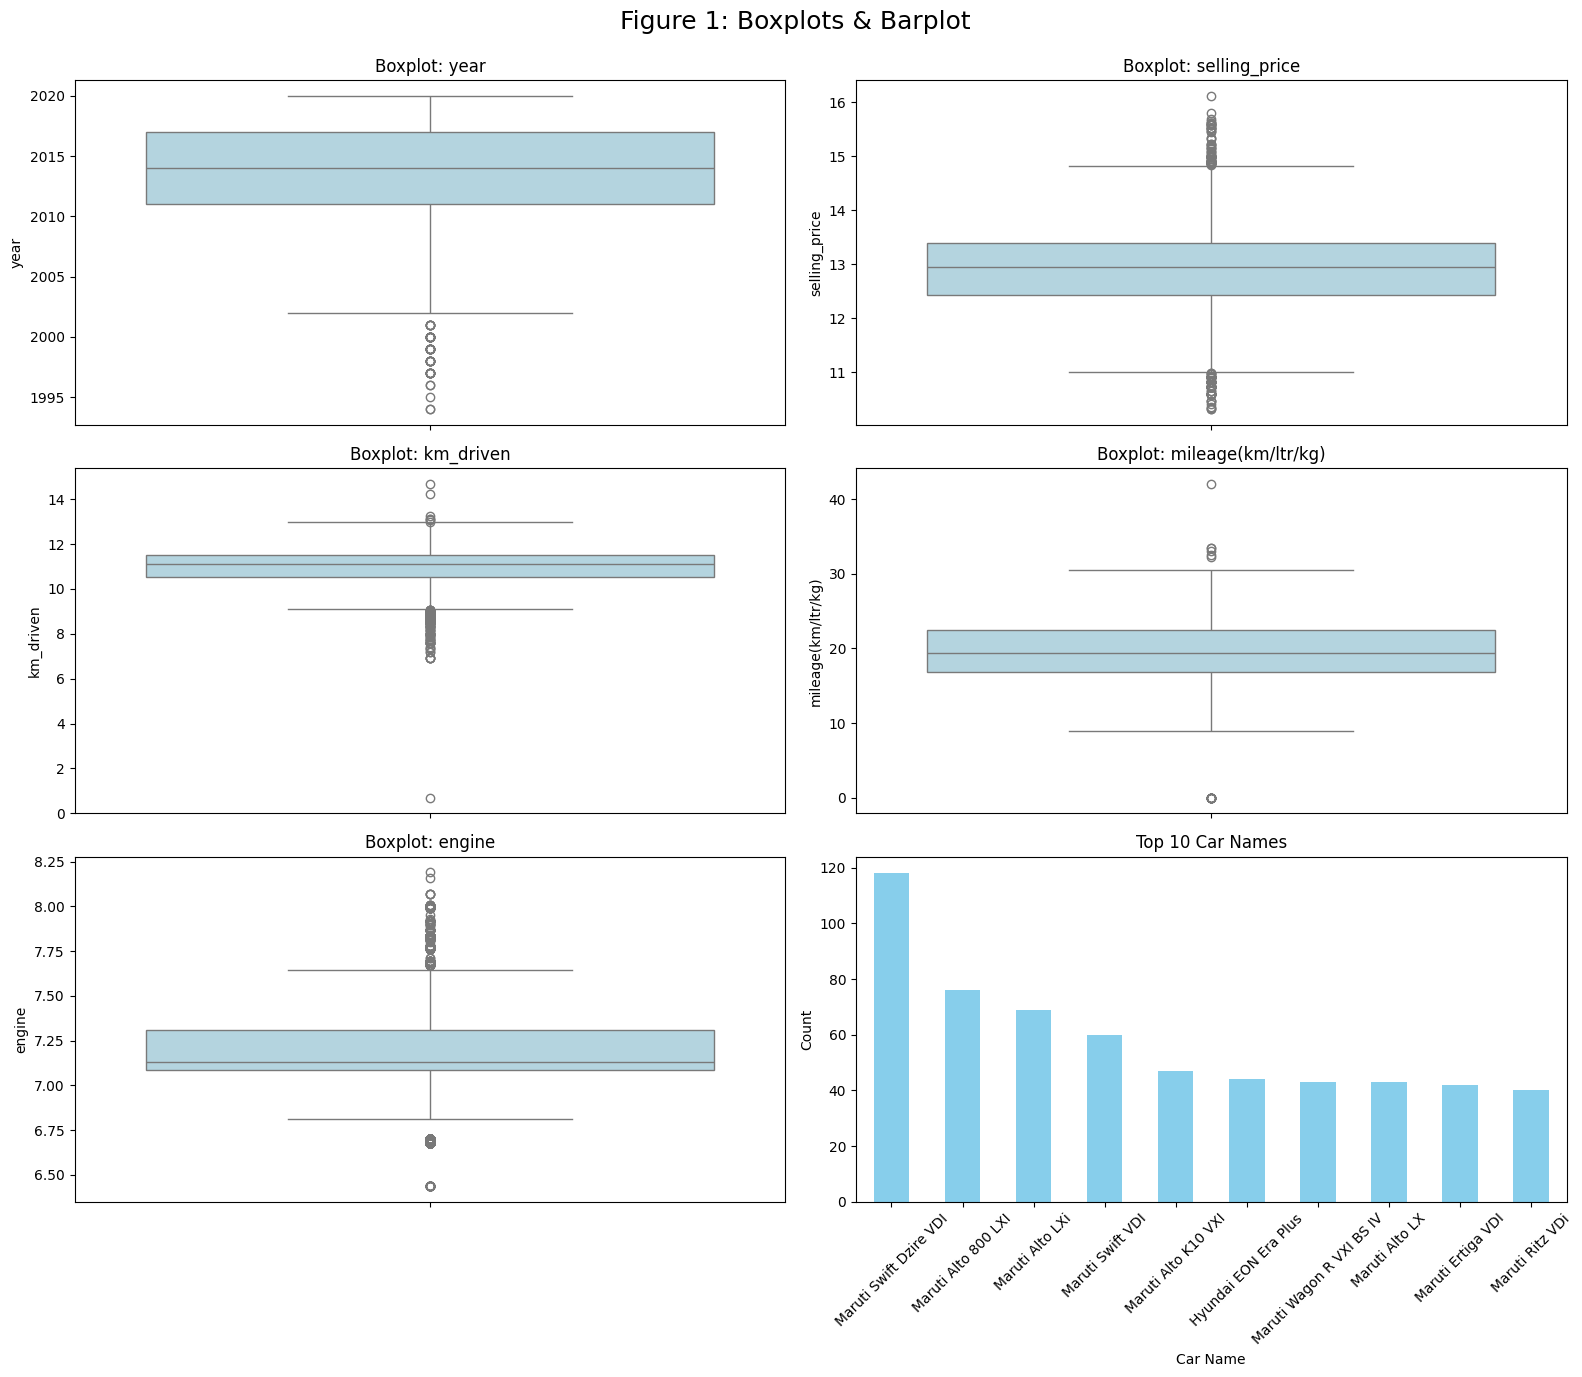

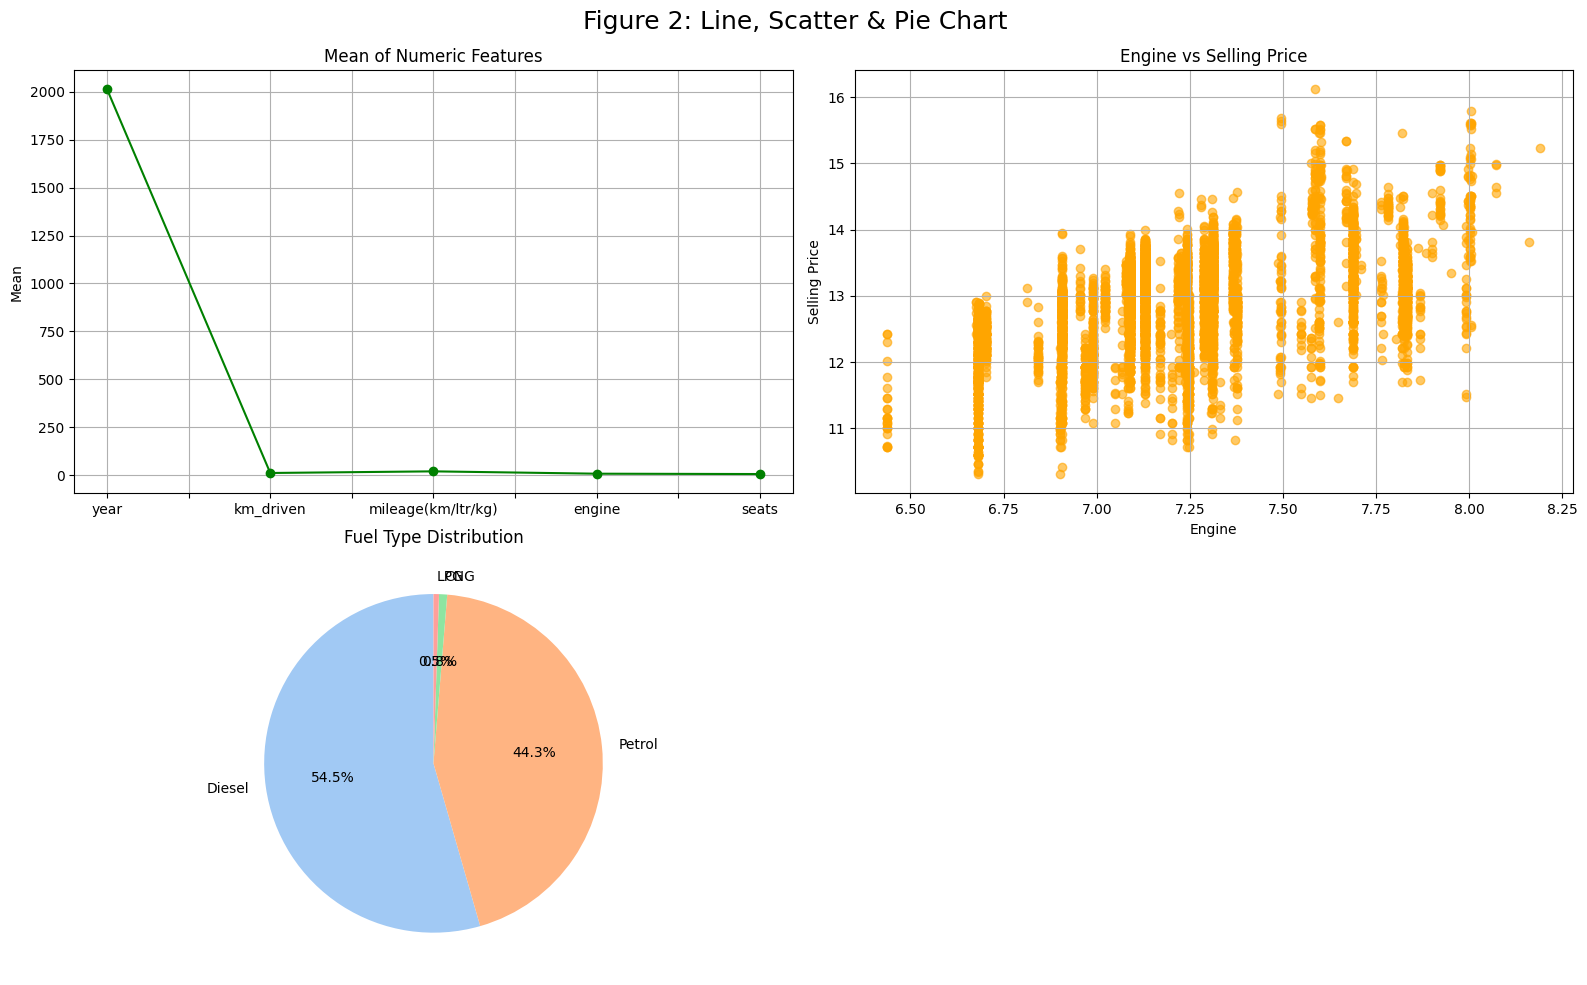

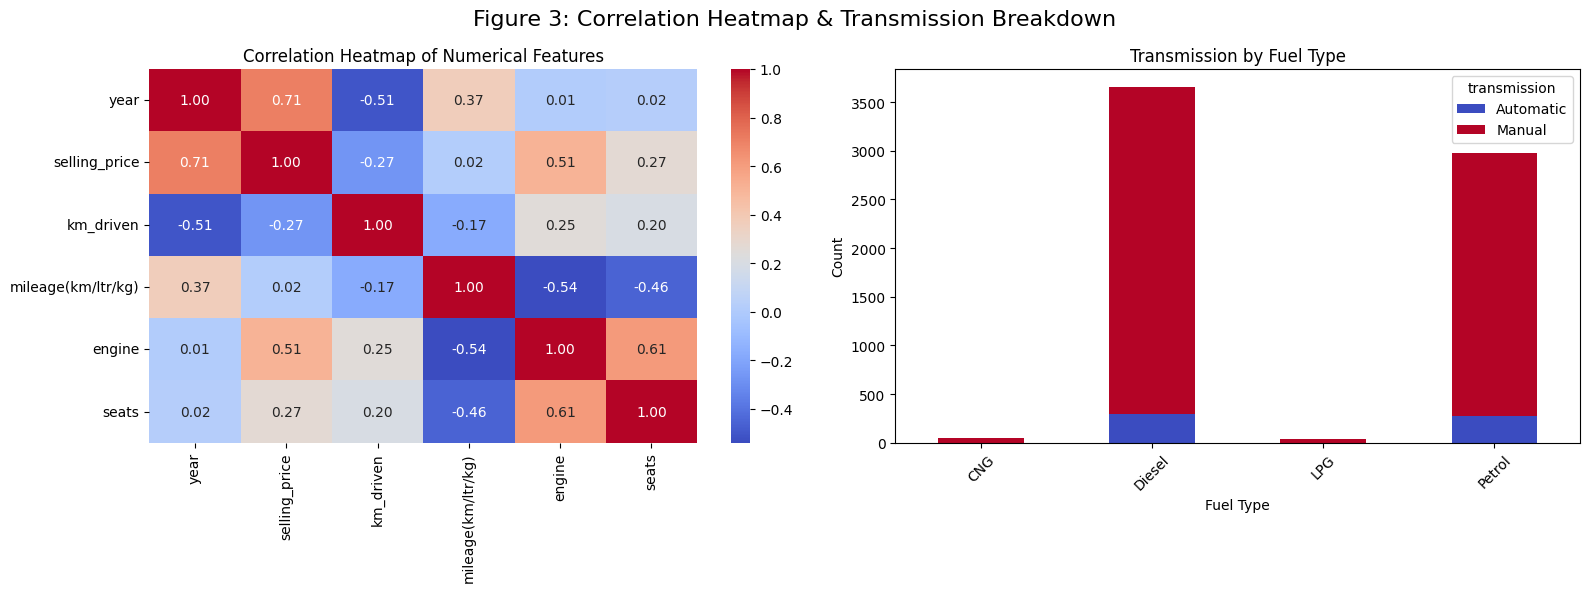

In [36]:
# Dataset Visualization
# ---------------- Figure 1: Boxplots and Barplot ----------------
fig1, axes1 = plt.subplots(3, 2, figsize=(16, 14))
axes1 = axes1.flatten()

# Boxplots
for i, col in enumerate(numeric_cols[:5]):
    sns.boxplot(data=car_dataset, y=col, ax=axes1[i], color='lightblue')
    axes1[i].set_title(f'Boxplot: {col}')
    axes1[i].set_xlabel('')

# Barplot: Top 10 car names
top_names = car_dataset['name'].value_counts().head(10)
top_names.plot(kind='bar', ax=axes1[5], color='skyblue')
axes1[5].set_title('Top 10 Car Names')
axes1[5].set_xlabel('Car Name')
axes1[5].set_ylabel('Count')
axes1[5].tick_params(axis='x', rotation=45)

fig1.tight_layout()
fig1.suptitle("Figure 1: Boxplots & Barplot", fontsize=18)
fig1.subplots_adjust(top=0.93)
plt.show()

# ---------------- Figure 2: 4 Subplots ----------------
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))

# Line Plot: Mean of numeric columns
num_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('selling_price', errors='ignore')  # Exclude target variable if present
car_dataset[num_cols].mean().plot(marker='o', ax=axes2[0, 0], color='green')
axes2[0, 0].set_title('Mean of Numeric Features')
axes2[0, 0].set_ylabel('Mean')
axes2[0, 0].grid(True)

# Scatter Plot: Engine vs Selling Price
axes2[0, 1].scatter(car_dataset['engine'], car_dataset['selling_price'], alpha=0.6, color='orange')
axes2[0, 1].set_title('Engine vs Selling Price')
axes2[0, 1].set_xlabel('Engine')
axes2[0, 1].set_ylabel('Selling Price')
axes2[0, 1].grid(True)

# Pie Chart: Fuel Type
car_dataset['fuel'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes2[1, 0], colors=sns.color_palette('pastel'))
axes2[1, 0].set_title('Fuel Type Distribution')
axes2[1, 0].set_ylabel('')

# Empty bottom-right plot (for aesthetics)
axes2[1, 1].axis('off')

fig2.tight_layout()
fig2.suptitle("Figure 2: Line, Scatter & Pie Chart", fontsize=18)
fig2.subplots_adjust(top=0.92)
plt.show()

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ---------------- Left Plot: Correlation Heatmap ----------------
sns.heatmap(car_dataset[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title('Correlation Heatmap of Numerical Features')

# ---------------- Right Plot: Stacked Bar Chart ----------------
if 'fuel' in car_dataset.columns and 'transmission' in car_dataset.columns:
    crosstab_data = pd.crosstab(car_dataset['fuel'], car_dataset['transmission'])
    crosstab_data.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax2)
    ax2.set_title('Transmission by Fuel Type')
    ax2.set_xlabel('Fuel Type')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

# Final layout tweaks
fig.tight_layout()
fig.suptitle("Figure 3: Correlation Heatmap & Transmission Breakdown", fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

Null rows in car_dataset

name                  0
year                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
Duplicate Rows in car_dataset: 0


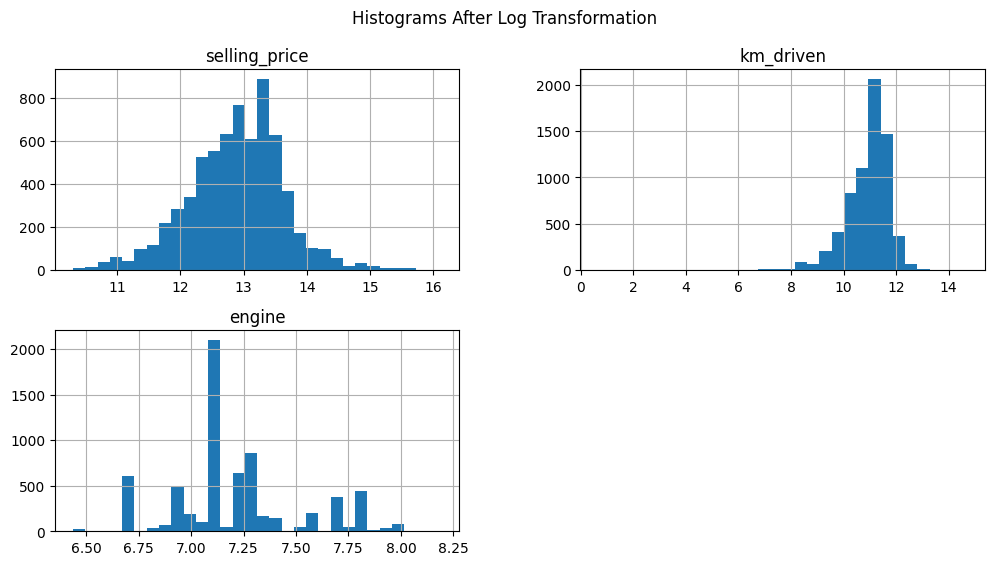

In [ ]:
# Step 1: Clean the dataset
car_dataset = car_dataset.dropna()
car_dataset = car_dataset.drop_duplicates()

print("Null rows in car_dataset\n")
print(car_dataset.isnull().sum().to_string())

print("Duplicate Rows in car_dataset:", car_dataset.duplicated().sum())

# Step 2: Log-transform skewed numerical columns
log_cols = ['selling_price', 'km_driven', 'engine']
for col in log_cols:
    car_dataset[col] = np.log1p(car_dataset[col])  # handles 0 safely

car_dataset[log_cols].hist(bins=30, figsize=(12, 6))
plt.suptitle("Histograms After Log Transformation")
plt.show()
X = car_dataset.drop(['selling_price', 'name'], axis=1).copy()
y = car_dataset['selling_price']


In [6]:
print("After transforming into logarthmic scale:")
car_dataset.describe()

After transforming into logarthmic scale:


,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,6718.000000,6718.000000,6718.000000,6718.00000,6718.000000,6718.000000
mean,2013.609110,12.889422,10.941721,19.46531,7.214460,5.434653
std,3.900648,0.750575,0.814100,4.04915,0.316112,0.984230
min,1994.000000,10.308953,0.693147,0.00000,6.437752,2.000000
25%,2011.000000,12.429220,10.545368,16.80000,7.088409,5.000000
50%,2014.000000,12.948012,11.130530,19.44000,7.130099,5.000000
75%,2017.000000,13.384729,11.512935,22.50000,7.312553,5.000000
max,2020.000000,16.118096,14.674366,42.00000,8.190077,14.000000


In [7]:
# 1. Define num cols
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 2. Define a function to remove outliers using IQR
def remove_outliers_iqr(X, y, num_cols, factor=1.5):
    mask = pd.Series([True] * X.shape[0], index=X.index)

    for col in num_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        mask &= (X[col] >= lower_bound) & (X[col] <= upper_bound)

    # Apply mask to both X and y
    X_clean = X.loc[mask]
    y_clean = y.loc[mask]

    return X_clean, y_clean

# 3. Apply the outlier removal function
X, y = remove_outliers_iqr(X, y, num_cols)

# Now split cleaned and deduplicated data into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)

#Split into test and val set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# 4. Show how many rows remained
print(f"Remaining samples after outlier removal: {X.shape[0]}")

Remaining samples after outlier removal: 4473


In [8]:
Total_shape = X_train.shape[0] + X_temp.shape[0]*2
Total_shape

5368

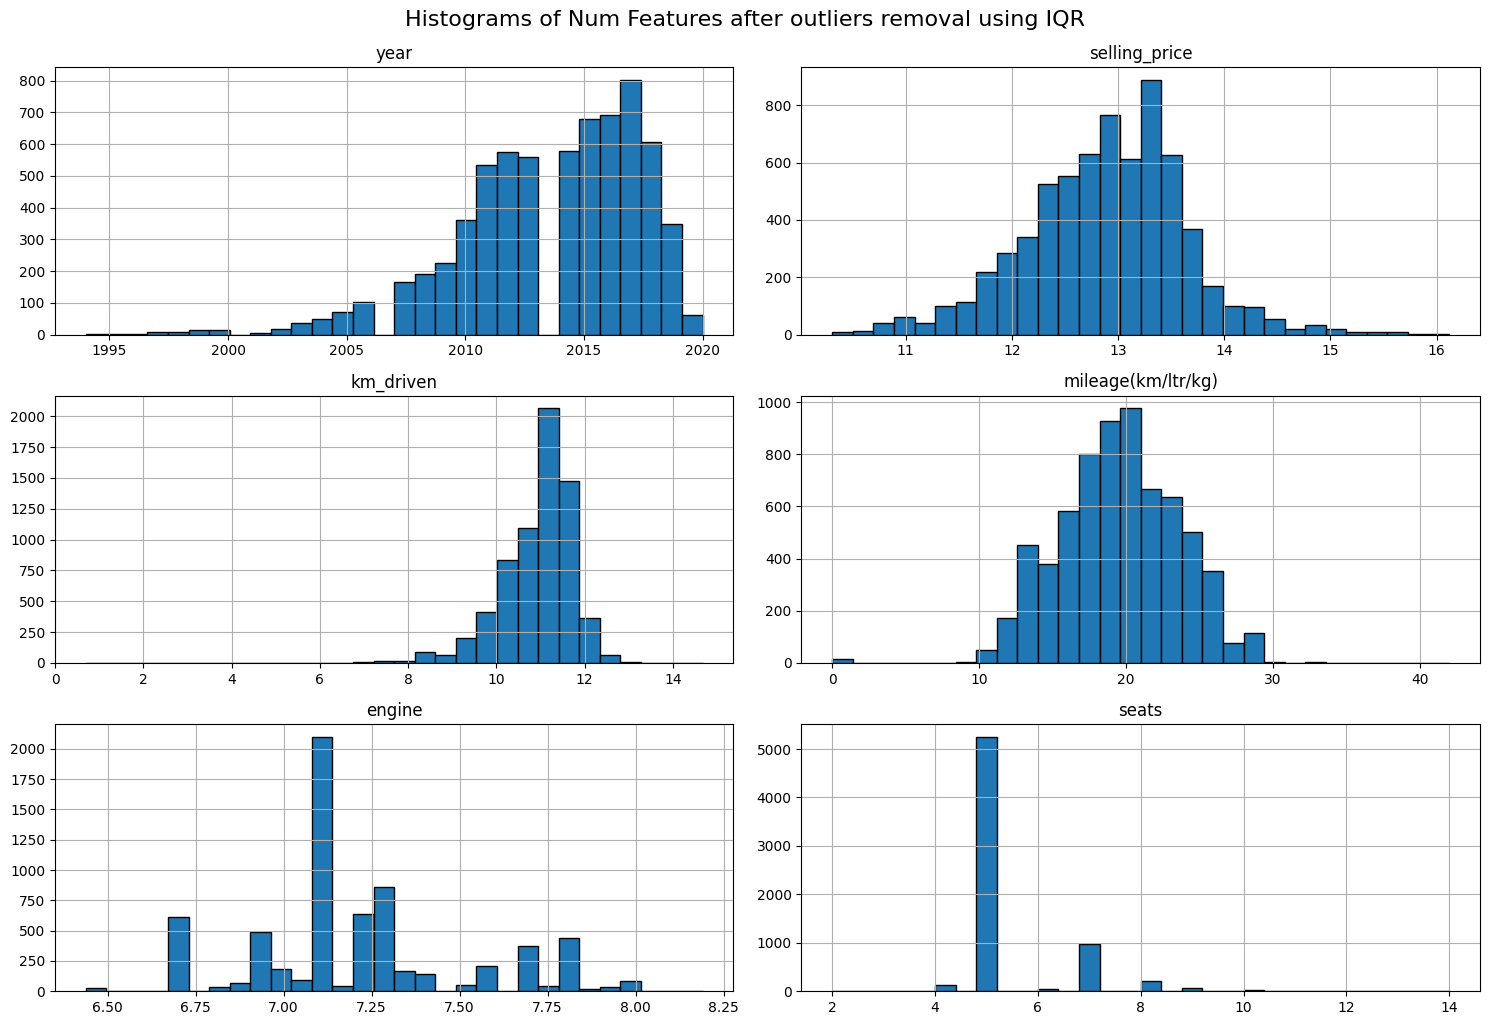

In [9]:
# Plot histogram for each numerical column
car_dataset[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle('Histograms of Num Features after outliers removal using IQR', fontsize=16, y=1.02)
plt.show()

In [10]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Impute numeric on X_train and transform X_val
num_imputer = SimpleImputer(strategy='mean')
X_train[num_cols] = pd.DataFrame(
    num_imputer.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)
X_val[num_cols] = pd.DataFrame(
    num_imputer.transform(X_val[num_cols]),
    columns=num_cols,
    index=X_val.index
)

# Impute categorical on X_train and transform X_val
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = pd.DataFrame(
    cat_imputer.fit_transform(X_train[cat_cols]),
    columns=cat_cols,
    index=X_train.index
)
X_val[cat_cols] = pd.DataFrame(
    cat_imputer.transform(X_val[cat_cols]),
    columns=cat_cols,
    index=X_val.index
)

In [11]:
X_test.isnull().sum()

year                  0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
dtype: int64

In [12]:
X_train.info()
X_val.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3578 entries, 7721 to 4981
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                3578 non-null   float64
 1   km_driven           3578 non-null   float64
 2   fuel                3578 non-null   object 
 3   seller_type         3578 non-null   object 
 4   transmission        3578 non-null   object 
 5   owner               3578 non-null   object 
 6   mileage(km/ltr/kg)  3578 non-null   float64
 7   engine              3578 non-null   float64
 8   max_power           3578 non-null   object 
 9   seats               3578 non-null   float64
dtypes: float64(5), object(5)
memory usage: 307.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 447 entries, 7171 to 7465
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                447 non-null    float64
 1

In [13]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Create pipelines
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
]) for name, model in models.items()}

# Fit and evaluate all models
best_model = None
best_score = -np.inf

for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    preds_log = pipe.predict(X_val)

    # Invert log1p transform for both prediction and true labels
    true_vals = np.expm1(y_val)
    pred_vals = np.expm1(preds_log)

    # Evaluate
    mae = mean_absolute_error(true_vals, pred_vals)
    r2 = r2_score(true_vals, pred_vals)
    print(f"{name} MAE: {mae:.2f}, R2: {r2:.3f}\n")

    # Track best overall model (optional)
    if r2 > best_score:
        best_score = r2
        best_model = pipe

# -------------------------
# Now, hyperparameter tuning for XGBoost using GridSearchCV on training data

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best CV R2 score:", grid_search.best_score_)

# Save the best tuned model pipeline
joblib.dump(grid_search.best_estimator_, '../model/xgboost_pipeline_tuned.pkl')
print("*Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*")


Training Linear Regression...
Linear Regression MAE: 80589.06, R2: 0.849

Training Random Forest...
Random Forest MAE: 71006.79, R2: 0.860

Training XGBoost...
XGBoost MAE: 72881.67, R2: 0.866

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 3578, number of used features: 65
[LightGBM] [Info] Start training from score 12.844372
LightGBM MAE: 73807.30, R2: 0.845

Fitting 5 folds for each of 27 candidates, totalling 135 fits


e:\ML_Project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best parameters found by GridSearchCV: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Best CV R2 score: 0.8860901866062468
*Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*


In [14]:
# Custom R² scorer that inverts log1p
def r2_log_inverse(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)

# Use make_scorer to create a scorer usable in cross_val_score
r2_custom_scorer = make_scorer(r2_log_inverse, greater_is_better=True)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Use cross_val_score with custom scorer
r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring=r2_custom_scorer)

print("Cross-val R2 scores (actual scale):", r2_scores)
print("Mean R2:", r2_scores.mean())

Cross-val R2 scores (actual scale): [0.85266752 0.92686103 0.87915624 0.66394884 0.73254988]
Mean R2: 0.8110367004731437


In [15]:
# Load the entire pipeline (includes preprocessor + model)
pipeline = joblib.load('../model/xgboost_pipeline_tuned.pkl')

In [24]:
# Predict (still in log scale)
y_pred_log = pipeline.predict(X_test)

# Invert transformation to get actual prices
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)  # Only if y_val was log1p-transformed

# Basic evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # in %

# Print results
print("📊 Model Evaluation Metrics on Test Set")
print(f"MAE  (Mean Absolute Error):        {mae:.2f}")
print(f"MSE  (Mean Squared Error):         {mse:.2f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.2f}")
print(f"R²   (R-squared):                  {r2:.4f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.2f}%")


📊 Model Evaluation Metrics on Test Set
MAE  (Mean Absolute Error):        61017.39
MSE  (Mean Squared Error):         9242890665.50
RMSE (Root Mean Squared Error):    96139.95
R²   (R-squared):                  0.9201
MAPE (Mean Absolute % Error):      15.02%


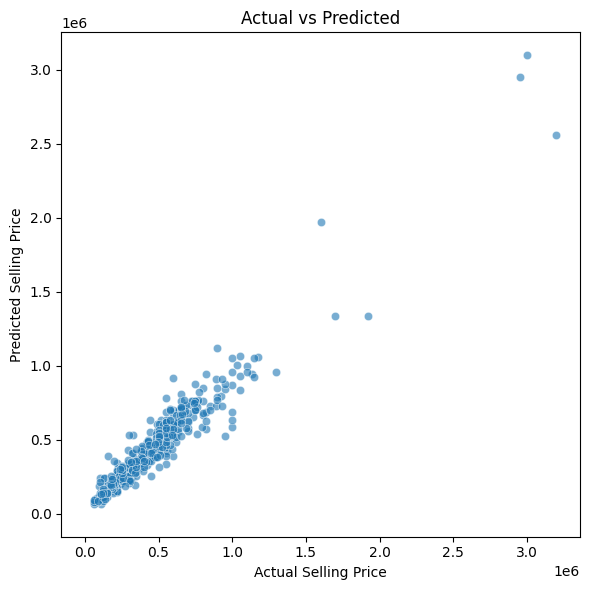

In [25]:
# Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Diagonal line
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

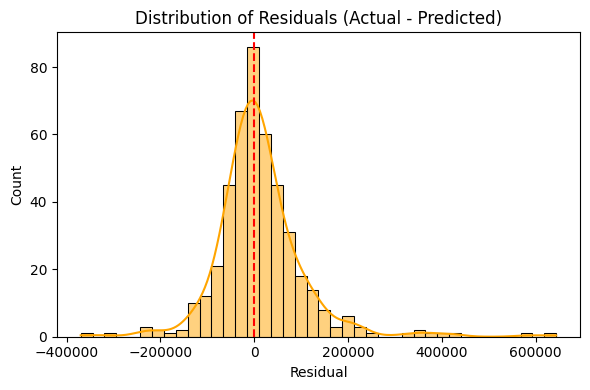

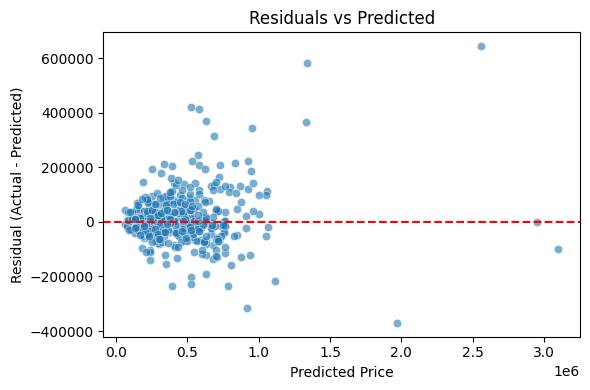

In [26]:
# Distribution of Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# Residuals vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12344\2300981732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], palette='viridis')


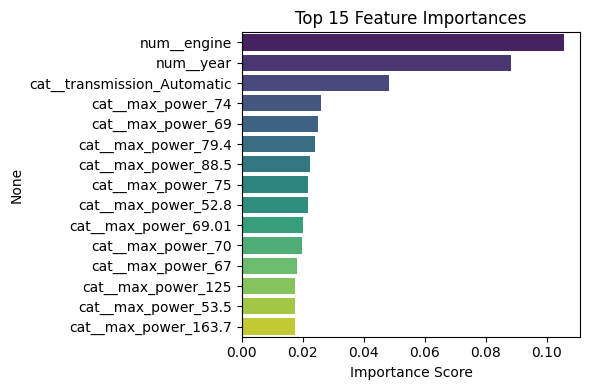

In [28]:
# Feature Importance Plot
# Extract feature importances from the XGBoost model
xgb_pipeline = joblib.load('../model/xgboost_pipeline_tuned.pkl')
importances = xgb_pipeline.named_steps['model'].feature_importances_
features = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], palette='viridis')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [20]:
# Make a copy to work safely
df = car_dataset.copy()

# 1. Car Age (Assuming current year is 2025)
df['car_age'] = 2025 - df['year']

# 2. Price per KM (avoid division by zero)
df['price_per_km'] = df['selling_price'] / (df['km_driven'] + 1)

# 3. Engine per Seat (avoid division by zero and NaNs)
df['engine_per_seat'] = df['engine'] / (df['seats'].replace(0, np.nan))

# Drop any rows with inf or NaN created
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['price_per_km', 'engine_per_seat'])

# Show new features
print(df[['car_age', 'price_per_km', 'engine_per_seat']].describe())

           car_age  price_per_km  engine_per_seat
count  6718.000000   6718.000000      6718.000000
mean     11.390890      1.086808         1.356605
std       3.900648      0.138606         0.171758
min       5.000000      0.800881         0.541077
25%       8.000000      1.006017         1.336922
50%      11.000000      1.069516         1.417682
75%      14.000000      1.146827         1.448846
max      31.000000      7.235103         3.916800


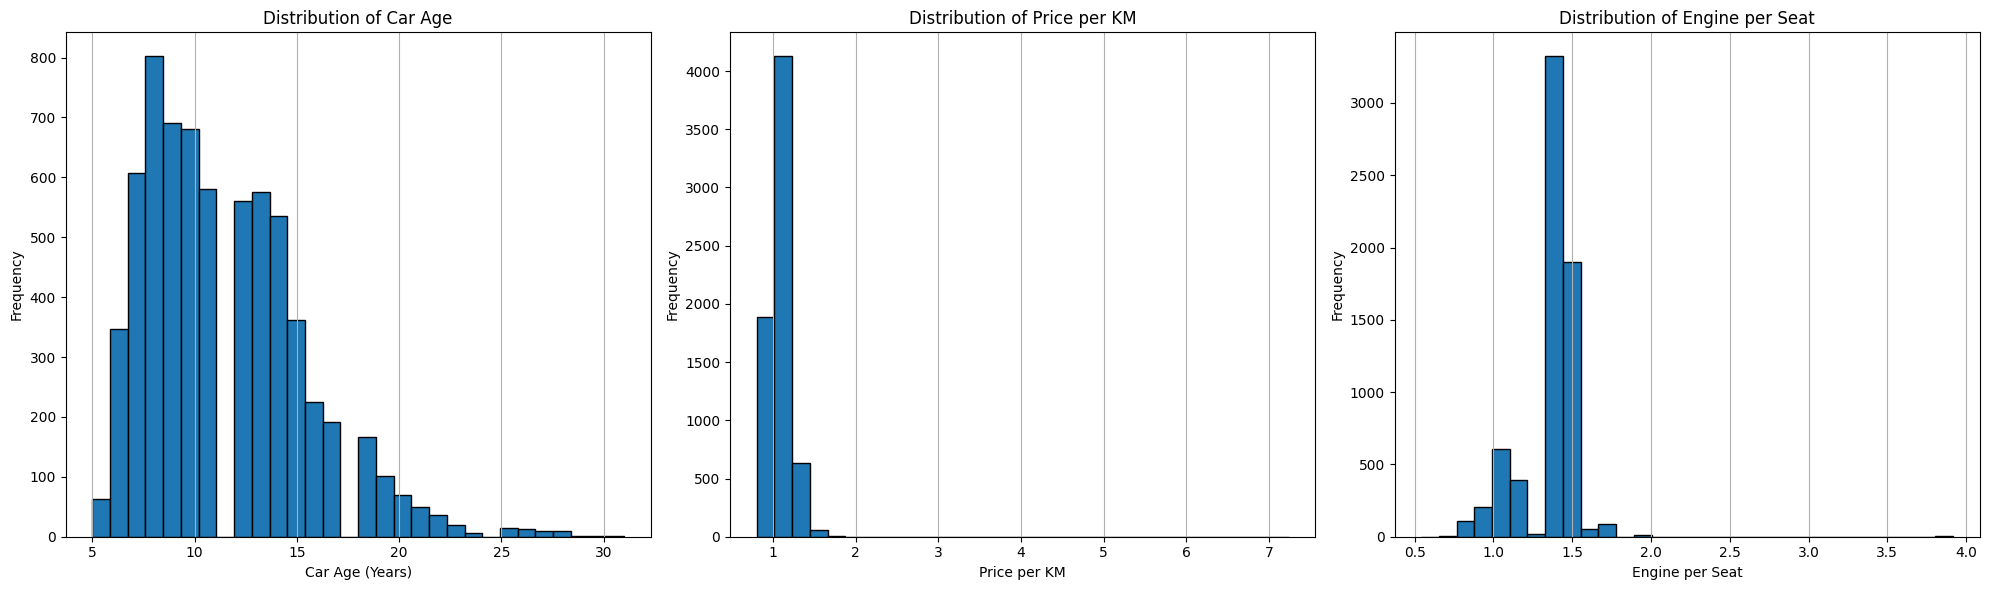

In [44]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the first histogram
df['car_age'].hist(bins=30, edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Car Age')
axes[0].set_xlabel('Car Age (Years)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

# Plot the second histogram
df['price_per_km'].hist(bins=30, edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Price per KM')
axes[1].set_xlabel('Price per KM')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

# Plot the third histogram
df['engine_per_seat'].hist(bins=30, edgecolor='black', ax=axes[2])
axes[2].set_title('Distribution of Engine per Seat')
axes[2].set_xlabel('Engine per Seat')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis='y')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
